In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from pmdarima import auto_arima

## Data Preprocessing

In [5]:
# Load data sets.

itemDf = pd.read_csv("../Data/item.csv")
promotionDf = pd.read_csv("../Data/promotion.csv")
salesDf = pd.read_csv("../Data/sales.csv")
supermarketsDf = pd.read_csv("../Data/supermarkets.csv")

In [6]:
salesDf

,code,amount,units,time,province,week,customerId,supermarket,basket,day,voucher
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0
3,9999985067,0.85,1,1148,2,1,162016,244,3,1,0
4,9999985131,2.19,1,1323,2,1,89437,244,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1048099,1510000011,2.35,1,1307,2,27,43825,346,665448,189,0
1048100,3620000489,0.99,1,1307,2,27,43825,346,665448,189,0
1048101,9999971309,2.00,2,1410,2,27,42140,346,665449,189,0
1048102,3620000250,1.98,2,1415,2,27,53544,346,665450,189,0


##### Visualization of daily sales

In [7]:
# Aggregate sales data to find daily sales.

daily_sales = salesDf.groupby('day')['amount'].sum().reset_index()
daily_sales_by_province = salesDf.groupby(['day', 'province'])['amount'].sum().reset_index()

In [8]:
daily_sales

,day,amount
0,1,20740.410
1,2,11754.540
2,3,10400.260
3,4,10602.675
4,5,9337.290
...,...,...
161,191,7159.270
162,192,5463.000
163,193,5788.450
164,194,4852.430


In [9]:
daily_sales_by_province

,day,province,amount
0,1,1,7244.79
1,1,2,13495.62
2,2,1,6344.45
3,2,2,5410.09
4,3,1,5499.18
...,...,...,...
297,191,1,7159.27
298,192,1,5463.00
299,193,1,5788.45
300,194,1,4852.43


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


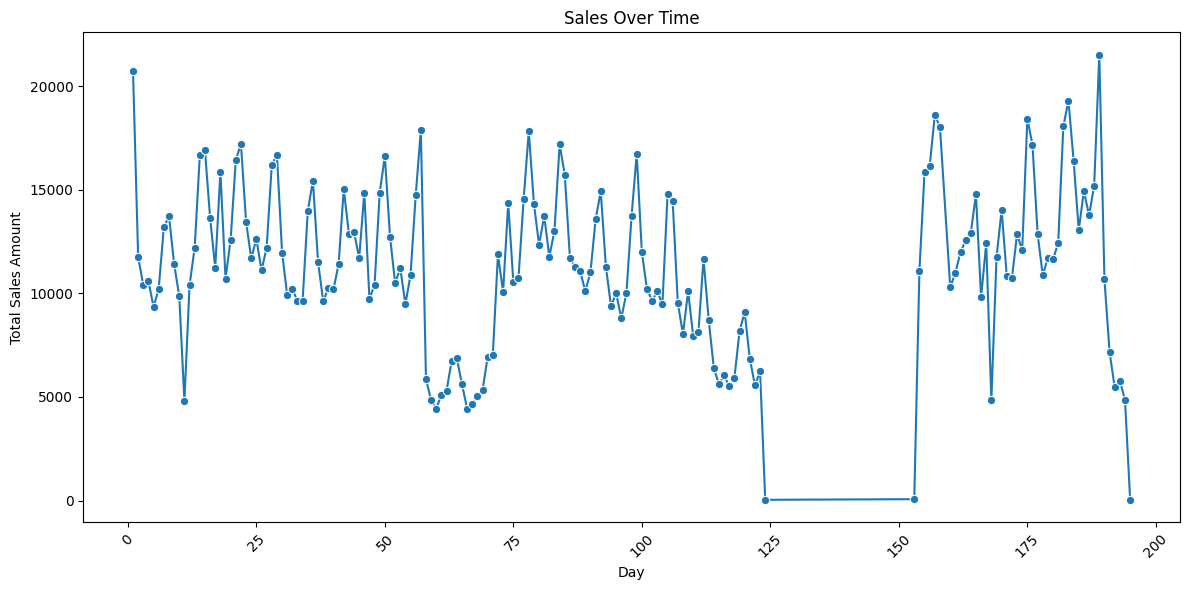

In [10]:
# Daily sales over time.

plt.figure(figsize=(12, 6))

sns.lineplot(data=daily_sales, x='day', y='amount', marker='o')

plt.title('Sales Over Time')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
daily_sales

,day,amount
0,1,20740.410
1,2,11754.540
2,3,10400.260
3,4,10602.675
4,5,9337.290
...,...,...
161,191,7159.270
162,192,5463.000
163,193,5788.450
164,194,4852.430


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


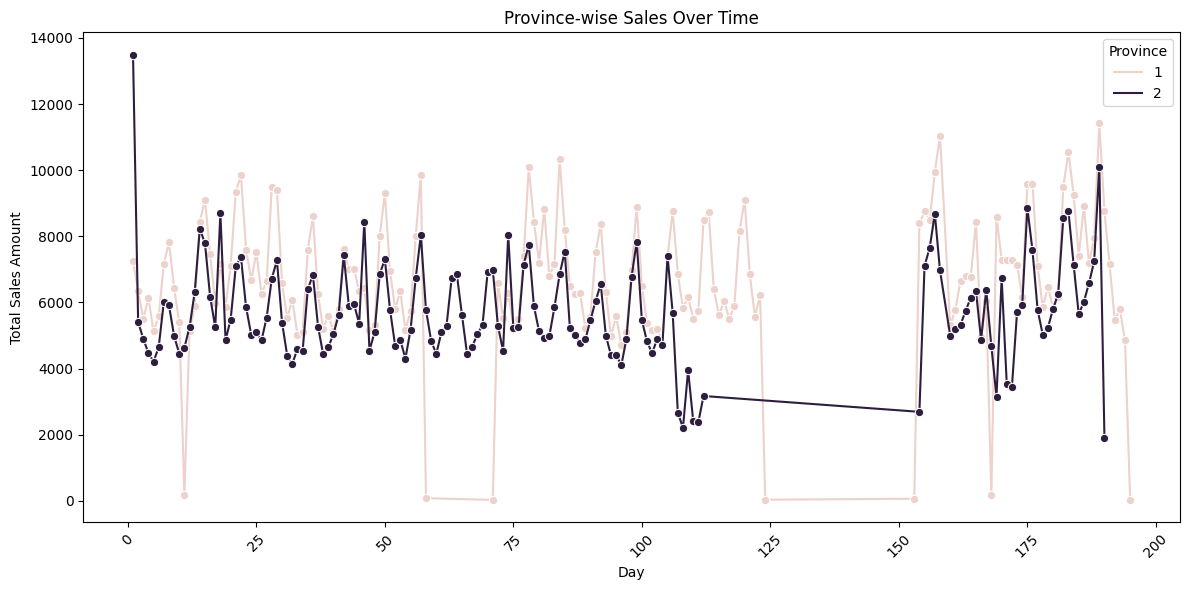

In [12]:
# Daily sales over time Province wise.

plt.figure(figsize=(12, 6))

sns.lineplot(data=daily_sales_by_province, x='day', y='amount', hue='province', marker='o')

plt.title('Province-wise Sales Over Time')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.legend(title='Province')
plt.tight_layout()
plt.show()
    

In [13]:
sales_province_1 = daily_sales_by_province[daily_sales_by_province['province'] == 1].reset_index(drop=True)
sales_province_2 = daily_sales_by_province[daily_sales_by_province['province'] == 2].reset_index(drop=True)

sales_province_1["Original_amount"] = sales_province_1["amount"]
sales_province_2["Original_amount"] = sales_province_2["amount"]

In [14]:
all_days = pd.DataFrame({'day': range(1, 196)})

sales_province_1 = all_days.merge(sales_province_1, on='day', how='left')
sales_province_2 = all_days.merge(sales_province_2, on='day', how='left')

##### Impute Missing values and Handle outliers for Province 1

In [15]:
p1_temp = sales_province_1.copy()
p1_temp.set_index('day', inplace=True)
p1_temp["imputed_amount"] = p1_temp["amount"]


In [16]:
p1_temp[p1_temp["amount"].isna()]

# Day 59-70, 125-152, 159 are missing

,province,amount,Original_amount,imputed_amount
day,,,,
59,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN
64,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN


In [17]:
# Use ARIMA model to impute missing values.

model1 = auto_arima(p1_temp[:58]['amount'], seasonal=True, m=12, trace=True, 
                    error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1040.264, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1038.913, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1037.416, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1032.913, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1190.358, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1034.956, Time=0.01 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1035.330, Time=0.08 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1034.995, Time=0.17 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1036.953, Time=0.04 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1037.327, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1034.168, Time=0.04 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1035.527, Time=0.04 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=1034.285, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1034.678, Time=0.06 sec
 ARIMA(1,0,2)(0,0,1

In [18]:
p1_temp["imputed_amount"][58:70] =  model1.predict(n_periods=12, return_conf_int=True)[0]

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [19]:
# # Use ARIMA model to impute missing values.

model2 = auto_arima(p1_temp[:124]['imputed_amount'], seasonal=True, m=28, trace=True, 
                    error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[28] intercept   : AIC=2201.615, Time=1.77 sec
 ARIMA(0,0,0)(0,0,0)[28] intercept   : AIC=2212.893, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[28] intercept   : AIC=2202.809, Time=0.49 sec
 ARIMA(0,0,1)(0,0,1)[28] intercept   : AIC=2201.672, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[28]             : AIC=2540.328, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[28] intercept   : AIC=2207.222, Time=0.75 sec
 ARIMA(2,0,2)(1,0,0)[28] intercept   : AIC=2204.399, Time=1.04 sec
 ARIMA(2,0,2)(2,0,1)[28] intercept   : AIC=inf, Time=30.47 sec
 ARIMA(2,0,2)(1,0,2)[28] intercept   : AIC=2201.030, Time=29.52 sec
 ARIMA(2,0,2)(0,0,2)[28] intercept   : AIC=2201.718, Time=24.58 sec
 ARIMA(2,0,2)(2,0,2)[28] intercept   : AIC=inf, Time=30.86 sec
 ARIMA(1,0,2)(1,0,2)[28] intercept   : AIC=inf, Time=23.08 sec
 ARIMA(2,0,1)(1,0,2)[28] intercept   : AIC=2203.528, Time=24.28 sec
 ARIMA(3,0,2)(1,0,2)[28] intercept   : AIC=2202.659, Time=29.54 sec
 ARIMA(2,0,3)(1,0,2)[28] in

In [20]:
p1_temp["imputed_amount"][124:152] =  model2.predict(n_periods=28, return_conf_int=True)[0]

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [21]:
p1_temp = p1_temp.reset_index()

In [22]:
sales_province_1["amount"] = p1_temp["imputed_amount"]

In [23]:
sales_province_1[sales_province_1["amount"].isna()]

,day,province,amount,Original_amount
158,159,NaN,NaN,NaN


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


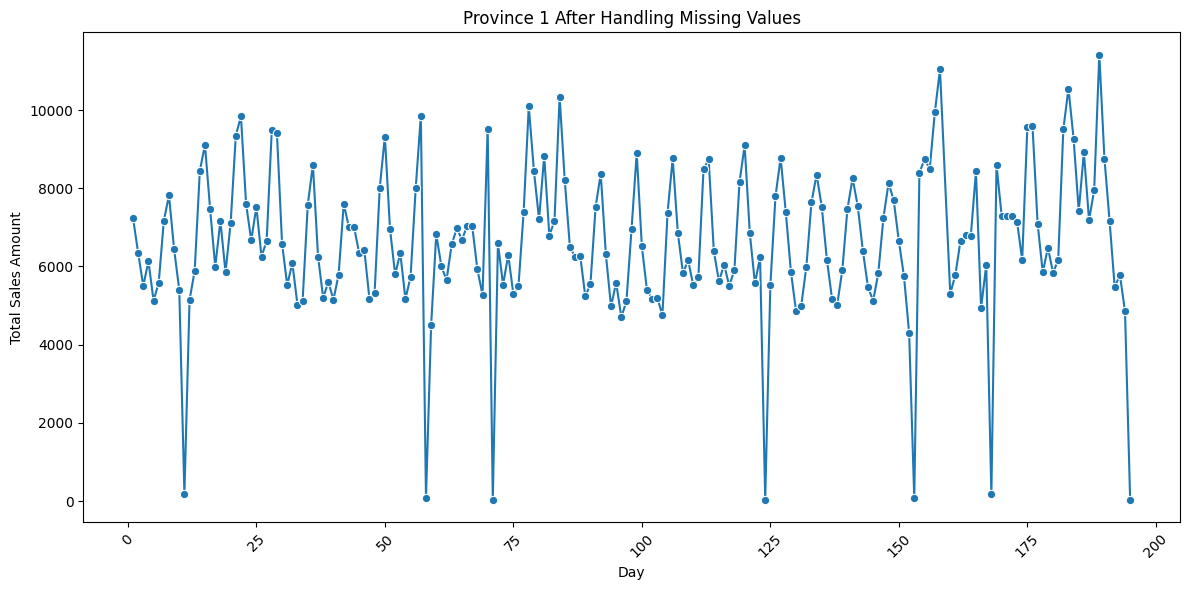

In [24]:
# Daily sales after handle missing values.

plt.figure(figsize=(12, 6))

sns.lineplot(data=sales_province_1, x='day', y='amount', marker='o')

plt.title('Province 1 After Handling Missing Values')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    

##### Identify outliers for Province 1

In [25]:
# Use Iforest for identify outlers.

sales_province_1['amount_filled'] = sales_province_1['amount'].fillna(0)

iso_forest = IsolationForest(contamination=0.1, random_state=42)
sales_province_1['outlier'] = iso_forest.fit_predict(sales_province_1[['amount_filled']])

sales_province_1.loc[sales_province_1['outlier'] == -1, 'amount_filled'] = np.nan 
sales_province_1.loc[sales_province_1['amount'] == 0, 'amount_filled'] = np.nan

#Outliers represented as -1 and amount as nan.

In [26]:
temp_p1 = sales_province_1.copy()

start_date = '2023-01-01'

temp_p1['date'] = pd.to_datetime(start_date) + pd.to_timedelta(temp_p1['day'] - 1, unit='D')

temp_p1 = temp_p1.set_index('date')

In [27]:
temp_p1

,day,province,amount,Original_amount,amount_filled,outlier
date,,,,,,
2023-01-01,1,1.0,7244.79,7244.79,7244.79,1
2023-01-02,2,1.0,6344.45,6344.45,6344.45,1
2023-01-03,3,1.0,5499.18,5499.18,5499.18,1
2023-01-04,4,1.0,6136.43,6136.43,6136.43,1
2023-01-05,5,1.0,5123.32,5123.32,5123.32,1
...,...,...,...,...,...,...
2023-07-10,191,1.0,7159.27,7159.27,7159.27,1
2023-07-11,192,1.0,5463.00,5463.00,5463.00,1
2023-07-12,193,1.0,5788.45,5788.45,5788.45,1


In [28]:
temp_p1['amount_imputed'] = temp_p1['amount_filled'].interpolate(method='time')

In [29]:
temp_p1 = temp_p1.reset_index()

In [30]:
sales_province_1["amount"] =  temp_p1["amount_imputed"]

In [31]:
sales_province_1["Original_amount"].fillna(0)

0      7244.79
1      6344.45
2      5499.18
3      6136.43
4      5123.32
        ...   
190    7159.27
191    5463.00
192    5788.45
193    4852.43
194      29.36
Name: Original_amount, Length: 195, dtype: float64

In [32]:
sales_province_1

,day,province,amount,Original_amount,amount_filled,outlier
0,1,1.0,7244.79,7244.79,7244.79,1
1,2,1.0,6344.45,6344.45,6344.45,1
2,3,1.0,5499.18,5499.18,5499.18,1
3,4,1.0,6136.43,6136.43,6136.43,1
4,5,1.0,5123.32,5123.32,5123.32,1
...,...,...,...,...,...,...
190,191,1.0,7159.27,7159.27,7159.27,1
191,192,1.0,5463.00,5463.00,5463.00,1
192,193,1.0,5788.45,5788.45,5788.45,1
193,194,1.0,4852.43,4852.43,4852.43,1


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

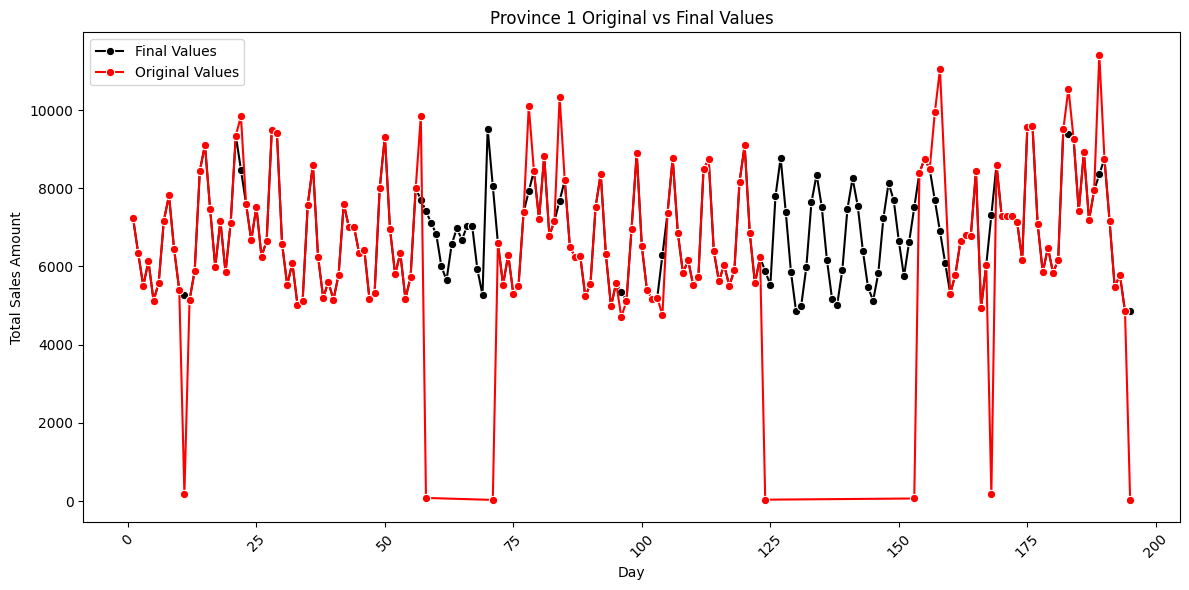

In [33]:
# Plot of Original daily sales and missing value and outlier handle sales data.

plt.figure(figsize=(12, 6))

sns.lineplot(data=sales_province_1, x='day', y='amount', marker='o', label='Final Values', color='black')

sns.lineplot(data=sales_province_1, x='day', y='Original_amount', marker='o', label='Original Values', color='red')

plt.title('Province 1 Original vs Final Values')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    

#### Impute Missing values and Handling outliers for Province 2

In [34]:
p2_temp = sales_province_2.copy()
p2_temp.set_index('day', inplace=True)
p2_temp["imputed_amount"] = p2_temp["amount"]

In [35]:
p2_temp[p2_temp["amount"].isna()]

# Day 113-153, 191-195 are missing

,province,amount,Original_amount,imputed_amount
day,,,,
113,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN
115,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN
119,NaN,NaN,NaN,NaN
120,NaN,NaN,NaN,NaN
121,NaN,NaN,NaN,NaN


In [36]:
p2_temp.loc[159, "imputed_amount"] = 0

In [37]:
# Use ARIMA model to impute missing values.

model1 = auto_arima(p2_temp[:112]['amount'], seasonal=True, m=41, trace=True, 
                    error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[41] intercept   : AIC=inf, Time=18.50 sec
 ARIMA(0,1,0)(0,0,0)[41] intercept   : AIC=1947.919, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[41] intercept   : AIC=1934.980, Time=4.76 sec
 ARIMA(0,1,1)(0,0,1)[41] intercept   : AIC=1909.261, Time=5.05 sec
 ARIMA(0,1,0)(0,0,0)[41]             : AIC=1946.330, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[41] intercept   : AIC=1911.658, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[41] intercept   : AIC=1911.319, Time=5.98 sec
 ARIMA(0,1,1)(0,0,2)[41] intercept   : AIC=1911.226, Time=13.42 sec
 ARIMA(0,1,1)(1,0,0)[41] intercept   : AIC=1909.580, Time=7.77 sec
 ARIMA(0,1,1)(1,0,2)[41] intercept   : AIC=1913.222, Time=26.27 sec
 ARIMA(0,1,0)(0,0,1)[41] intercept   : AIC=1944.864, Time=4.28 sec
 ARIMA(1,1,1)(0,0,1)[41] intercept   : AIC=inf, Time=11.38 sec
 ARIMA(0,1,2)(0,0,1)[41] intercept   : AIC=inf, Time=12.79 sec
 ARIMA(1,1,0)(0,0,1)[41] intercept   : AIC=1935.536, Time=1.75 sec
 ARIMA(1,1,2)(0,0,1)[41] inte

In [38]:
p2_temp["imputed_amount"][112:153] =  model1.predict(n_periods=41, return_conf_int=True)[0]

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [39]:
model2 = auto_arima(p2_temp[:190]['imputed_amount'], seasonal=True, m=5, trace=True, 
                    error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=3337.120, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=3321.401, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=3276.735, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=3335.388, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=3275.320, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[5] intercept   : AIC=3276.867, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=3265.452, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[5] intercept   : AIC=3268.399, Time=0.16 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=3267.374, Time=0.25 sec
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=3269.349, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=3320.201, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=3264.678, Time=0.16 sec
 ARIMA(2,1,1)(1,0,0)[5] intercept   : AIC=3

In [40]:
p2_temp["imputed_amount"][190:]=  model2.predict(n_periods=5, return_conf_int=True)[0]

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [41]:
p2_temp

,province,amount,Original_amount,imputed_amount
day,,,,
1,2.0,13495.620,13495.620,13495.620000
2,2.0,5410.090,5410.090,5410.090000
3,2.0,4901.080,4901.080,4901.080000
4,2.0,4466.245,4466.245,4466.245000
5,2.0,4213.970,4213.970,4213.970000
...,...,...,...,...
191,NaN,NaN,NaN,5318.422580
192,NaN,NaN,NaN,6011.089746
193,NaN,NaN,NaN,6103.243756


In [42]:
p2_temp = p2_temp.reset_index()
sales_province_2["amount"] = p2_temp["imputed_amount"]
sales_province_2[sales_province_2["amount"].isna()]

,day,province,amount,Original_amount


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


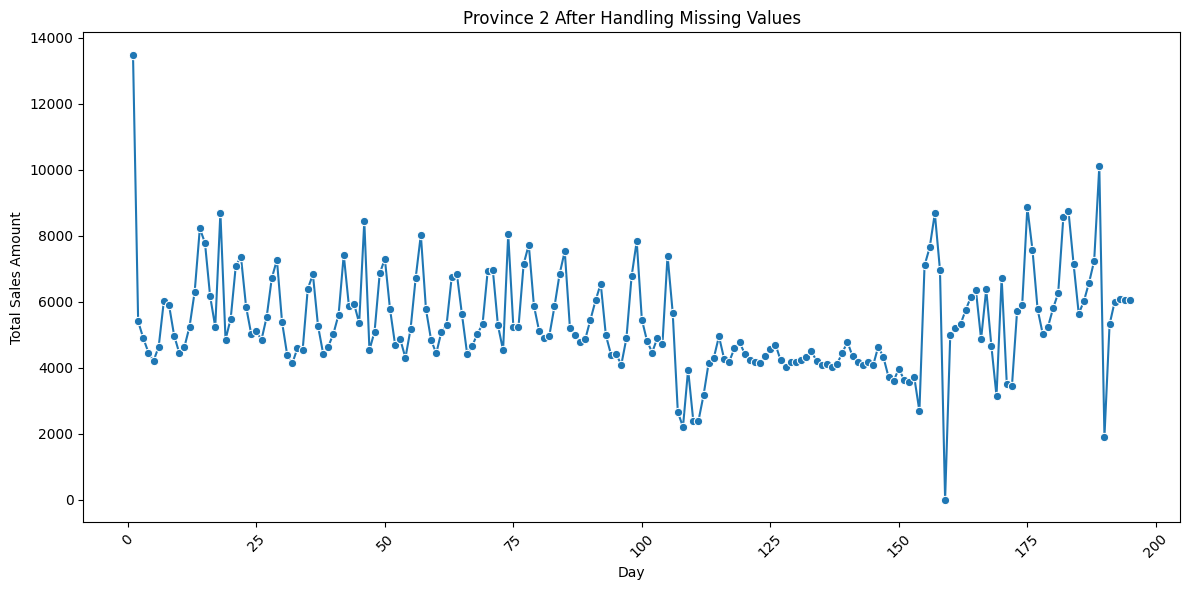

In [43]:
# Daily sales after handle missing values.

plt.figure(figsize=(12, 6))

sns.lineplot(data=sales_province_2, x='day', y='amount', marker='o')

plt.title('Province 2 After Handling Missing Values')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    

##### Identify outliers for Province 2

In [44]:
# Use Iforest for identify outliers.

sales_province_2['amount_filled'] = sales_province_2['amount'].fillna(0)

iso_forest = IsolationForest(contamination=0.1, random_state=42)
sales_province_2['outlier'] = iso_forest.fit_predict(sales_province_2[['amount_filled']])

sales_province_2.loc[sales_province_2['outlier'] == -1, 'amount_filled'] = np.nan 
sales_province_2.loc[sales_province_2['amount'] == 0, 'amount_filled'] = np.nan

#Outliers represented as -1 and amount as nan.

In [45]:
temp_p2 = sales_province_2.copy()

start_date = '2023-01-01'

temp_p2['date'] = pd.to_datetime(start_date) + pd.to_timedelta(temp_p2['day'] - 1, unit='D')

temp_p2 = temp_p2.set_index('date')

In [46]:
temp_p2['amount_imputed'] = temp_p2['amount_filled'].interpolate(method='time')
temp_p2 = temp_p2.reset_index()
sales_province_2["amount"] =  temp_p2["amount_imputed"]
sales_province_2["Original_amount"].fillna(0)

0      13495.620
1       5410.090
2       4901.080
3       4466.245
4       4213.970
         ...    
190        0.000
191        0.000
192        0.000
193        0.000
194        0.000
Name: Original_amount, Length: 195, dtype: float64

In [47]:
sales_province_2.loc[0,"amount"] = 13495.62

c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

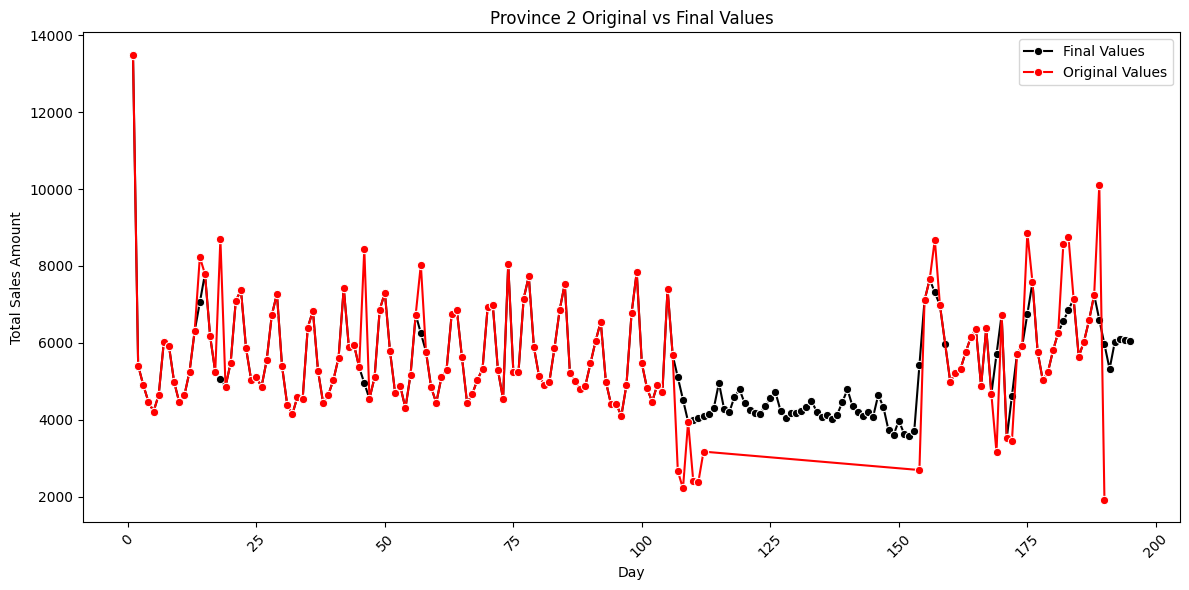

In [48]:
# Plot of Original daily sales and missing value and outlier handle sales data.

plt.figure(figsize=(12, 6))

sns.lineplot(data=sales_province_2, x='day', y='amount', marker='o', label='Final Values', color='black')

sns.lineplot(data=sales_province_2, x='day', y='Original_amount', marker='o', label='Original Values', color='red')

plt.title('Province 2 Original vs Final Values')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
sales_province_2

,day,province,amount,Original_amount,amount_filled,outlier
0,1,2.0,13495.620000,13495.620,NaN,-1
1,2,2.0,5410.090000,5410.090,5410.090000,1
2,3,2.0,4901.080000,4901.080,4901.080000,1
3,4,2.0,4466.245000,4466.245,4466.245000,1
4,5,2.0,4213.970000,4213.970,4213.970000,1
...,...,...,...,...,...,...
190,191,NaN,5318.422580,NaN,5318.422580,1
191,192,NaN,6011.089746,NaN,6011.089746,1
192,193,NaN,6103.243756,NaN,6103.243756,1
193,194,NaN,6073.319991,NaN,6073.319991,1


##### Final Data Set for Total daily sales after missing value and outlier handle.

In [50]:
final_sales = sales_province_1
final_sales["amount"] = sales_province_1["amount"]+sales_province_2["amount"]

In [51]:
final_sales = final_sales.drop(["province","Original_amount", "amount_filled", "outlier"], axis=1)

In [52]:
final_sales['amount'] = final_sales['amount'].round(2)

In [53]:
final_sales

,day,amount
0,1,20740.41
1,2,11754.54
2,3,10400.26
3,4,10602.68
4,5,9337.29
...,...,...
190,191,12477.69
191,192,11474.09
192,193,11891.69
193,194,10925.75


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

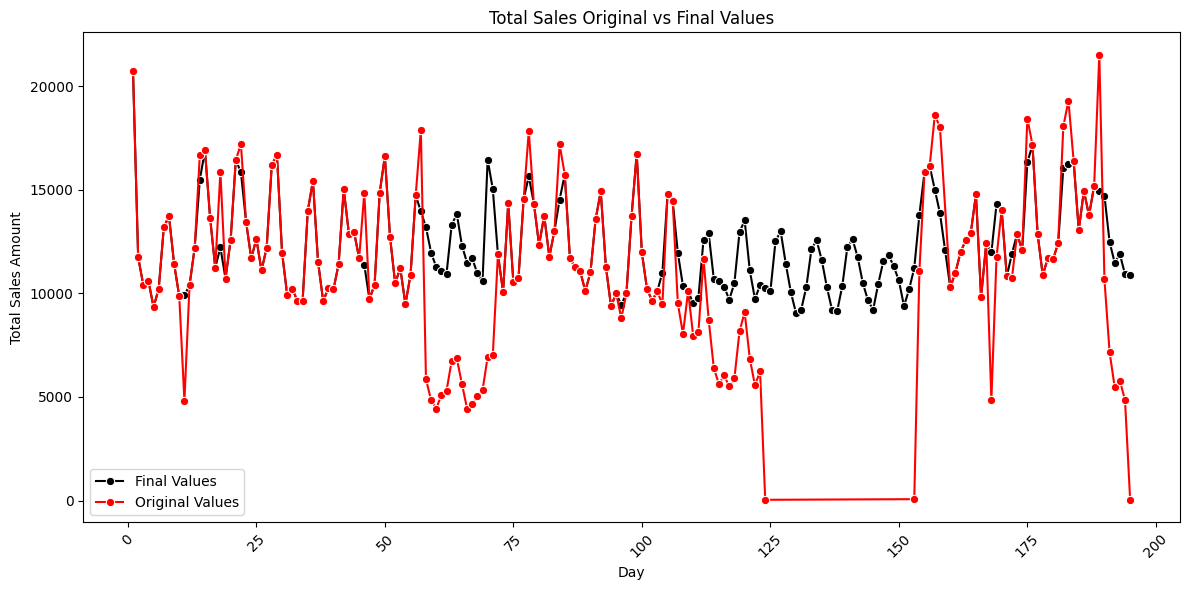

In [54]:
# Plot of Original daily sales and missing value and outlier handle sales data.

plt.figure(figsize=(12, 6))

sns.lineplot(data=final_sales, x='day', y='amount', marker='o', label='Final Values', color='black')

sns.lineplot(data=daily_sales, x='day', y='amount', marker='o', label='Original Values', color='red')

plt.title('Total Sales Original vs Final Values')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Forecasting Model for next Month (30 days)

In [55]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [56]:
data = final_sales.copy()

start_date = '2024-01-01'

data['day'] = pd.to_datetime(start_date) + pd.to_timedelta(data['day'] - 1, unit='D')

data.set_index('day', inplace=True)
data = data.sort_index()

In [57]:
# Create lagged features.

def create_lagged_features(df, lag=30):
    df_lagged = df.copy()
    for i in range(1, lag + 1):
        df_lagged[f'lag_{i}'] = df_lagged['amount'].shift(i)
    df_lagged.dropna(inplace=True)
    return df_lagged

lagged_data = create_lagged_features(data, lag=30)

In [58]:
lagged_data

,amount,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
day,,,,,,,,,,,,,,,,,,,,,
2024-01-31,9917.10,11969.29,16686.28,16208.08,12193.12,11108.96,12626.46,11689.13,13451.70,15840.32,...,9850.52,11417.58,13724.40,13197.57,10228.29,9337.29,10602.68,10400.26,11754.54,20740.41
2024-02-01,10228.96,9917.10,11969.29,16686.28,16208.08,12193.12,11108.96,12626.46,11689.13,13451.70,...,9905.94,9850.52,11417.58,13724.40,13197.57,10228.29,9337.29,10602.68,10400.26,11754.54
2024-02-02,9617.80,10228.96,9917.10,11969.29,16686.28,16208.08,12193.12,11108.96,12626.46,11689.13,...,10389.79,9905.94,9850.52,11417.58,13724.40,13197.57,10228.29,9337.29,10602.68,10400.26
2024-02-03,9652.40,9617.80,10228.96,9917.10,11969.29,16686.28,16208.08,12193.12,11108.96,12626.46,...,12201.49,10389.79,9905.94,9850.52,11417.58,13724.40,13197.57,10228.29,9337.29,10602.68
2024-02-04,13974.94,9652.40,9617.80,10228.96,9917.10,11969.29,16686.28,16208.08,12193.12,11108.96,...,15495.62,12201.49,10389.79,9905.94,9850.52,11417.58,13724.40,13197.57,10228.29,9337.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-09,12477.69,14716.94,14953.06,15189.18,13766.60,14942.87,13054.60,16408.76,16236.78,16064.80,...,14030.06,14296.46,11981.02,12411.89,9816.39,14774.71,12928.60,12553.74,11983.02,10997.57
2024-07-10,11474.09,12477.69,14716.94,14953.06,15189.18,13766.60,14942.87,13054.60,16408.76,16236.78,...,10815.32,14030.06,14296.46,11981.02,12411.89,9816.39,14774.71,12928.60,12553.74,11983.02
2024-07-11,11891.69,11474.09,12477.69,14716.94,14953.06,15189.18,13766.60,14942.87,13054.60,16408.76,...,11913.06,10815.32,14030.06,14296.46,11981.02,12411.89,9816.39,14774.71,12928.60,12553.74


In [59]:
# Take last 30 days as test set.

train_data = lagged_data[:135]
test_data = lagged_data[135:]

In [60]:
X_train = train_data.drop(columns=['amount'])
y_train = train_data['amount']
X_test = test_data.drop(columns=['amount'])
y_test = test_data['amount']

## Linear Regression

In [169]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
print(f'Train MAE: {mean_absolute_error(y_train, y_train_pred)}')

cv_scores = cross_val_score(lr_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print(f'Train CV MAE: {np.mean(-cv_scores)}')

y_pred = lr_model.predict(X_test)
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')

Train MAE: 672.49618932266
Train CV MAE: 932.0304721868599
Test MAE: 1657.2120399923215


## Random Forest

In [170]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
print(f'Train MAE: {mean_absolute_error(y_train, y_train_pred)}')

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print(f'Train CV MAE: {np.mean(-cv_scores)}')

y_pred = rf_model.predict(X_test)
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')

Train MAE: 338.23629629629585
Train CV MAE: 1056.849041043956
Test MAE: 1615.146123333333


## k-Nearest Neighbors

In [173]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

y_train_pred = knn_model.predict(X_train)
print(f'Train MAE: {mean_absolute_error(y_train, y_train_pred)}')

cv_scores = cross_val_score(knn_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print(f'Train CV MAE: {np.mean(-cv_scores)}')

y_pred = knn_model.predict(X_test)
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')

Train MAE: 673.6561037037038
Train CV MAE: 939.2027153846153
Test MAE: 1257.7539333333336


## SVM

In [175]:
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

y_train_pred = svm_model.predict(X_train)
print(f'Train MAE: {mean_absolute_error(y_train, y_train_pred)}')

cv_scores = cross_val_score(svm_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print(f'Train CV MAE: {np.mean(-cv_scores)}')

y_pred = svm_model.predict(X_test)
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')

Train MAE: 1548.4328199332226
Train CV MAE: 1573.1960512013843
Test MAE: 2061.6923492180163


## XGB

In [177]:
xgb_model = XGBRegressor(objective='reg:squarederror',random_state=42)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
print(f'Train MAE: {mean_absolute_error(y_train, y_train_pred)}')

cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print(f'Train CV MAE: {np.mean(-cv_scores)}')

y_pred = xgb_model.predict(X_test)
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')

Train MAE: 0.0011362847222092872
Train CV MAE: 1142.1200762362637
Test MAE: 1643.1964205729164


## Optimized Random Forest Model

In [58]:
# Use Optuna to hyperparameter tuning.

def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    
    
    y_pred = rf_model.predict(X_test)
    
    
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [59]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)


[I 2024-10-22 12:20:41,553] A new study created in memory with name: no-name-330c9bee-906c-45ba-89cd-35f18dd4c129
[I 2024-10-22 12:20:41,821] Trial 0 finished with value: 1608.710505813774 and parameters: {'n_estimators': 204, 'max_depth': 24, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 0 with value: 1608.710505813774.
[I 2024-10-22 12:20:41,944] Trial 1 finished with value: 1718.2308172314492 and parameters: {'n_estimators': 132, 'max_depth': 25, 'min_samples_split': 14, 'min_samples_leaf': 14}. Best is trial 0 with value: 1608.710505813774.
[I 2024-10-22 12:20:42,077] Trial 2 finished with value: 1713.304884627068 and parameters: {'n_estimators': 126, 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 12}. Best is trial 0 with value: 1608.710505813774.
[I 2024-10-22 12:20:42,201] Trial 3 finished with value: 1719.2272335944187 and parameters: {'n_estimators': 122, 'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 14}. Best is trial 0 with value

In [60]:
# Best Model.

print('Best trial:')
print(study.best_trial)
print(f'Best hyperparameters: {study.best_params}')

Best trial:
FrozenTrial(number=164, state=1, values=[1507.614446136271], datetime_start=datetime.datetime(2024, 10, 22, 12, 21, 8, 868241), datetime_complete=datetime.datetime(2024, 10, 22, 12, 21, 8, 979306), params={'n_estimators': 55, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_depth': IntDistribution(high=50, log=False, low=5, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1)}, trial_id=164, value=None)
Best hyperparameters: {'n_estimators': 55, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 3}


In [61]:
best_params = study.best_params
rf_model_optimized = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
rf_model_optimized.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=7,
                      n_estimators=55, random_state=42)

In [72]:
# Evaluation of the model.

y_train_pred = rf_model_optimized.predict(X_train)
print(f'Train MAE: {mean_absolute_error(y_train, y_train_pred)}')

cv_scores = cross_val_score(rf_model_optimized, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print(f'Train CV MAE: {np.mean(-cv_scores)}')

y_pred = rf_model_optimized.predict(X_test)
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')

Train MAE: 457.0034197118965
Train CV MAE: 1051.308535358949
Test MAE: 1507.614446136271


### Optimized XGB Model

In [76]:
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    
    xgb_model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    
    
    y_pred = xgb_model.predict(X_test)
    
    
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [77]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2024-10-22 12:47:36,321] A new study created in memory with name: no-name-6c0abf51-ee1c-49c1-b982-ac88f385a48d
[I 2024-10-22 12:47:38,417] Trial 0 finished with value: 1756.2601263020829 and parameters: {'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.13481714305205258, 'min_child_weight': 8, 'subsample': 0.9858461571691005, 'colsample_bytree': 0.685055815848632}. Best is trial 0 with value: 1756.2601263020829.
[I 2024-10-22 12:47:38,665] Trial 1 finished with value: 1522.6041158854166 and parameters: {'n_estimators': 92, 'max_depth': 8, 'learning_rate': 0.13077821380626706, 'min_child_weight': 5, 'subsample': 0.5596436160711122, 'colsample_bytree': 0.5213884864676019}. Best is trial 1 with value: 1522.6041158854166.
[I 2024-10-22 12:47:38,811] Trial 2 finished with value: 1530.952927083333 and parameters: {'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.21670313568925934, 'min_child_weight': 4, 'subsample': 0.7420510749770712, 'colsample_bytree': 0.7095073633057083}

In [78]:
# Best xgb model.

print('Best trial:')
print(study.best_trial)
print(f'Best hyperparameters: {study.best_params}')

Best trial:
FrozenTrial(number=982, state=1, values=[1346.2190104166666], datetime_start=datetime.datetime(2024, 10, 22, 12, 57, 17, 906790), datetime_complete=datetime.datetime(2024, 10, 22, 12, 57, 18, 272345), params={'n_estimators': 154, 'max_depth': 5, 'learning_rate': 0.2748921851051701, 'min_child_weight': 4, 'subsample': 0.5159539278432638, 'colsample_bytree': 0.7822676712593993}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, trial_id=982, value=None)
Best hyperparameters: {'n_estimators': 154, 'max_depth': 5, 'learning_ra

In [79]:
best_params = study.best_params
xgb_model_optimized = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)
xgb_model_optimized.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7822676712593993, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2748921851051701, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=154, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [80]:
# Evaluate the optimized xgb model.

y_train_pred = xgb_model_optimized.predict(X_train)
print(f'Train MAE: {mean_absolute_error(y_train, y_train_pred)}')

cv_scores = cross_val_score(xgb_model_optimized, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print(f'Train CV MAE: {np.mean(-cv_scores)}')

y_pred = xgb_model_optimized.predict(X_test)
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')

Train MAE: 2.836620370370306
Train CV MAE: 1133.8220511675822
Test MAE: 1346.2190104166666


## Optimized KNN

In [180]:
def objective(trial):
    
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 100)
    
    model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size
    )
    
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')
    return score.mean()

In [181]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2024-10-22 16:07:29,275] A new study created in memory with name: no-name-aac8c759-4939-4017-a1d7-b8aba19cc680
[I 2024-10-22 16:07:29,371] Trial 0 finished with value: -1238.3173436692507 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 18}. Best is trial 0 with value: -1238.3173436692507.
[I 2024-10-22 16:07:29,725] Trial 1 finished with value: -1184.3254914914914 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 27}. Best is trial 1 with value: -1184.3254914914914.
[I 2024-10-22 16:07:30,080] Trial 2 finished with value: -1271.6619001610306 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 22}. Best is trial 1 with value: -1184.3254914914914.
[I 2024-10-22 16:07:30,121] Trial 3 finished with value: -1028.8435679012346 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 70}. Best is trial 3 with value: -1028

In [182]:
# Best KNN model.

print('Best trial:')
print(study.best_trial)
print(f'Best hyperparameters: {study.best_params}')

Best trial:
FrozenTrial(number=107, state=1, values=[-953.435378110907], datetime_start=datetime.datetime(2024, 10, 22, 16, 8, 14, 534464), datetime_complete=datetime.datetime(2024, 10, 22, 16, 8, 14, 646585), params={'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 85}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=50, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'algorithm': CategoricalDistribution(choices=('auto', 'ball_tree', 'kd_tree', 'brute')), 'leaf_size': IntDistribution(high=100, log=False, low=10, step=1)}, trial_id=107, value=None)
Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 85}


In [183]:
best_params = study.best_params
knn_model_optimized = KNeighborsRegressor(**best_params)
knn_model_optimized.fit(X_train, y_train)

KNeighborsRegressor(algorithm='ball_tree', leaf_size=85, n_neighbors=2,
                    weights='distance')

In [184]:
# Evaluate the optimized knn model.

y_train_pred = knn_model_optimized.predict(X_train)
print(f'Train MAE: {mean_absolute_error(y_train, y_train_pred)}')

cv_scores = cross_val_score(knn_model_optimized, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print(f'Train CV MAE: {np.mean(-cv_scores)}')

y_pred = knn_model_optimized.predict(X_test)
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')

Train MAE: 0.0
Train CV MAE: 999.406066884601
Test MAE: 1585.8957041187832


## Best ML Model

In [191]:
# Prediction for next 30 days. for optimized rf

last_values = train_data.iloc[-1, 1:].values.reshape(1, -1)
future_predictions = []
for _ in range(30):
    next_pred = xgb_model_optimized.predict(last_values)
    future_predictions.append(next_pred[0])
    last_values = np.roll(last_values, -1)
    last_values[0, -1] = next_pred[0]

future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'day': future_dates, 'amount': future_predictions})
future_df.set_index('day', inplace=True)

In [192]:
future_df

,amount
day,
2024-07-14,14761.382812
2024-07-15,12586.811523
2024-07-16,12459.371094
2024-07-17,12377.745117
2024-07-18,11556.772461
2024-07-19,10958.626953
2024-07-20,12575.863281
2024-07-21,12683.377930
2024-07-22,14214.039062


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

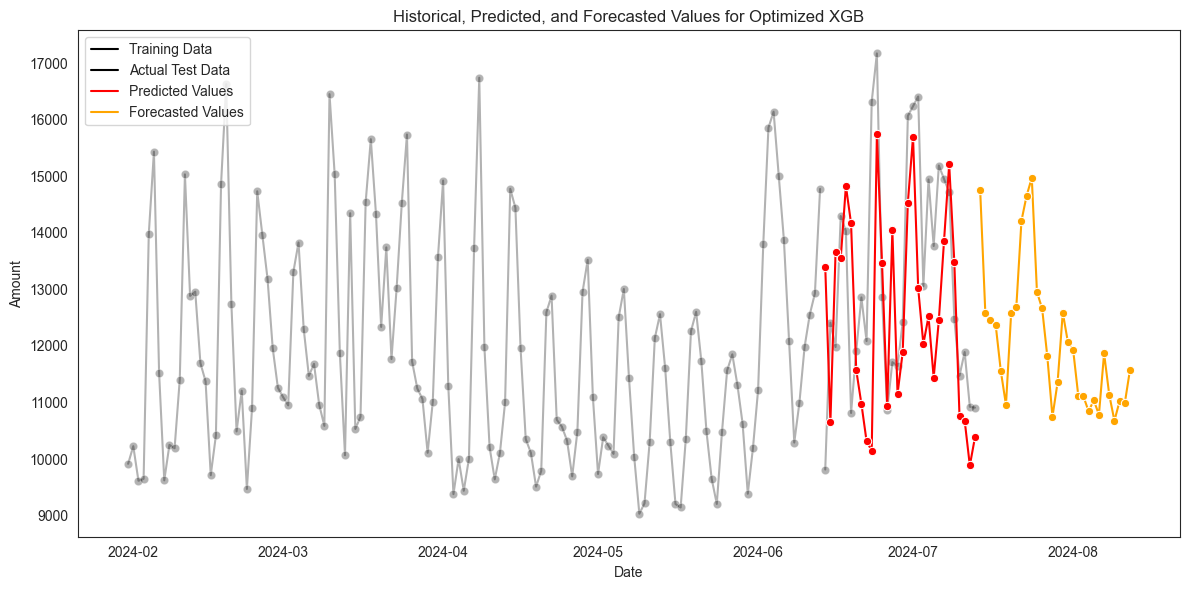

In [194]:
sns.set_style('white')

plot_df = pd.DataFrame({
    'Date': np.concatenate([train_data.index, test_data.index]),
    'Amount': np.concatenate([y_train, y_test]),
    'Type': ['Training Data'] * len(y_train) + ['Actual Test Data'] * len(y_test)
})

pred_df = pd.DataFrame({
    'Date': test_data.index,
    'Amount': y_pred,
    'Type': ['Predicted Values'] * len(y_pred)
})

forecast_df = pd.DataFrame({
    'Date': future_df.index,
    'Amount': future_df['amount'],
    'Type': ['Forecasted Values'] * len(future_df)
})

combined_df = pd.concat([plot_df, pred_df, forecast_df])

plt.figure(figsize=(12, 6))

sns.lineplot(data=combined_df[combined_df['Type'].isin(['Training Data', 'Actual Test Data'])],
             x='Date', y='Amount', hue='Type', palette=['black', 'black'], marker='o', alpha=0.3) 

sns.lineplot(data=combined_df[combined_df['Type'].isin(['Predicted Values', 'Forecasted Values'])],
             x='Date', y='Amount', hue='Type', palette=['red', 'orange'], marker='o')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Historical, Predicted, and Forecasted Values for Optimized XGB')

plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


## Preprocesing data for NN

In [61]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow import keras


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU, Conv1D, Flatten, MultiHeadAttention, Input
from tensorflow.keras.models import Model
from keras.optimizers import Adam

In [62]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['amount'].values.reshape(-1, 1))

In [63]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [64]:
time_step = 30  
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## MLP

In [202]:
# MLP architecture.

def build_model(input_shape):
    model = keras.Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

# Create and train the model.
mlp_model = build_model((X_train.shape[1],))
history = mlp_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/1000
4/4 [==============================] - 3s 190ms/step - loss: 0.1220 - val_loss: 0.1089
Epoch 2/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.0951 - val_loss: 0.1140
Epoch 3/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.0805 - val_loss: 0.1069
Epoch 4/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0699 - val_loss: 0.1138
Epoch 5/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0655 - val_loss: 0.1162
Epoch 6/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0648 - val_loss: 0.1185
Epoch 7/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.0637 - val_loss: 0.1201
Epoch 8/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0603 - val_loss: 0.1131
Epoch 9/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.0626 - val_loss: 0.1126
Epoch 10/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.0590 - val_loss: 0.1114
Epoch 11

In [203]:
# Evaluate the MLP model.

y_train_pred = mlp_model.predict(X_train)
y_train_pred_inverse = scaler.inverse_transform(y_train_pred)

y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
print(f'Train MAE: {mean_absolute_error(y_train_inverse, y_train_pred_inverse)}')



y_pred = mlp_model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f'Test MAE: {mean_absolute_error(y_test_inverse, y_pred_inverse)}')

5/5 [==============================] - 0s 4ms/step
Train MAE: 295.56757037213737
2/2 [==============================] - 0s 6ms/step
Test MAE: 1732.74939749053


## RNN

In [75]:
# Create Rnn model and train.

rnn_model = Sequential()
rnn_model.add(SimpleRNN(64, activation='relu', input_shape=(time_step, 1), return_sequences=True))
rnn_model.add(SimpleRNN(32, activation='relu'))
rnn_model.add(Dense(1))


rnn_model.compile(optimizer='adam', loss='mean_squared_error')
history = rnn_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
4/4 [==============================] - 2s 98ms/step - loss: 0.2029 - val_loss: 0.1043
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1008 - val_loss: 0.0580
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0613 - val_loss: 0.0357
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0418 - val_loss: 0.0244
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0301 - val_loss: 0.0191
Epoch 6/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0248 - val_loss: 0.0208
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0259 - val_loss: 0.0174
Epoch 8/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0221 - val_loss: 0.0157
Epoch 9/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0200 - val_loss: 0.0146
Epoch 10/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0185 - val_loss: 0.0135
Epoch 11/

In [76]:
# Evaluate the Rnn model.

y_train_pred = rnn_model.predict(X_train)
y_train_pred_inverse = scaler.inverse_transform(y_train_pred)

y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
print(f'Train MAE: {mean_absolute_error(y_train_inverse, y_train_pred_inverse)}')



y_pred = rnn_model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f'Test MAE: {mean_absolute_error(y_test_inverse, y_pred_inverse)}')

5/5 [==============================] - 0s 3ms/step
Train MAE: 287.99141459923663
2/2 [==============================] - 0s 0s/step
Test MAE: 1416.2522668087124


## LSTM

In [207]:
# Create LSTM model and train.

lstm_model = keras.Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(time_step, 1), return_sequences=True))
lstm_model.add(LSTM(32, activation='relu'))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

history = lstm_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
4/4 [==============================] - 12s 435ms/step - loss: 0.0859 - val_loss: 0.0665
Epoch 2/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0748 - val_loss: 0.0579
Epoch 3/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.0626 - val_loss: 0.0473
Epoch 4/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.0477 - val_loss: 0.0349
Epoch 5/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0302 - val_loss: 0.0269
Epoch 6/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0285 - val_loss: 0.0301
Epoch 7/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0318 - val_loss: 0.0269
Epoch 8/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0268 - val_loss: 0.0279
Epoch 9/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0285 - val_loss: 0.0287
Epoch 10/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.0289 - val_loss: 0.0281
Epoch 1

In [208]:
# Evaluate the Lstm model.

y_train_pred = lstm_model.predict(X_train)
y_train_pred_inverse = scaler.inverse_transform(y_train_pred)

y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
print(f'Train MAE: {mean_absolute_error(y_train_inverse, y_train_pred_inverse)}')



y_pred = lstm_model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f'Test MAE: {mean_absolute_error(y_test_inverse, y_pred_inverse)}')

5/5 [==============================] - 1s 9ms/step
Train MAE: 756.5667634780533
2/2 [==============================] - 0s 12ms/step
Test MAE: 2194.7130717329546


## GRU

In [209]:
gru_model = Sequential()
gru_model.add(GRU(64, activation='relu', input_shape=(time_step, 1), return_sequences=True))
gru_model.add(GRU(32, activation='relu'))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')

history = gru_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
4/4 [==============================] - 12s 465ms/step - loss: 0.0795 - val_loss: 0.0604
Epoch 2/1000
4/4 [==============================] - 0s 71ms/step - loss: 0.0682 - val_loss: 0.0516
Epoch 3/1000
4/4 [==============================] - 0s 73ms/step - loss: 0.0581 - val_loss: 0.0433
Epoch 4/1000
4/4 [==============================] - 0s 68ms/step - loss: 0.0484 - val_loss: 0.0355
Epoch 5/1000
4/4 [==============================] - 0s 68ms/step - loss: 0.0391 - val_loss: 0.0288
Epoch 6/1000
4/4 [==============================] - 0s 73ms/step - loss: 0.0316 - val_loss: 0.0256
Epoch 7/1000
4/4 [==============================] - 0s 68ms/step - loss: 0.0277 - val_loss: 0.0271
Epoch 8/1000
4/4 [==============================] - 0s 68ms/step - loss: 0.0286 - val_loss: 0.0286
Epoch 9/1000
4/4 [==============================] - 0s 68ms/step - loss: 0.0291 - val_loss: 0.0272
Epoch 10/1000
4/4 [==============================] - 0s 73ms/step - loss: 0.0280 - val_loss: 0.0260
Epoch 1

In [210]:
# Evaluate the GRU model.

y_train_pred = gru_model.predict(X_train)
y_train_pred_inverse = scaler.inverse_transform(y_train_pred)

y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
print(f'Train MAE: {mean_absolute_error(y_train_inverse, y_train_pred_inverse)}')



y_pred = gru_model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f'Test MAE: {mean_absolute_error(y_test_inverse, y_pred_inverse)}')

5/5 [==============================] - 1s 9ms/step
Train MAE: 437.1366850548664
2/2 [==============================] - 0s 17ms/step
Test MAE: 1716.1618821022726


## CNN

In [211]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_step, 1)))
cnn_model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(16, activation='relu'))
cnn_model.add(Dense(1))

cnn_model.compile(optimizer='adam', loss='mean_squared_error')
history = cnn_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
4/4 [==============================] - 4s 244ms/step - loss: 0.0765 - val_loss: 0.0417
Epoch 2/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.0347 - val_loss: 0.0257
Epoch 3/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.0283 - val_loss: 0.0242
Epoch 4/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 5/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.0196 - val_loss: 0.0261
Epoch 6/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0166 - val_loss: 0.0236
Epoch 7/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.0130 - val_loss: 0.0209
Epoch 8/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.0111 - val_loss: 0.0200
Epoch 9/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.0099 - val_loss: 0.0207
Epoch 10/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0092 - val_loss: 0.0226
Epoch 11

In [212]:
# Evaluate the CNN model.

y_train_pred = cnn_model.predict(X_train)
y_train_pred_inverse = scaler.inverse_transform(y_train_pred)

y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
print(f'Train MAE: {mean_absolute_error(y_train_inverse, y_train_pred_inverse)}')



y_pred = cnn_model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f'Test MAE: {mean_absolute_error(y_test_inverse, y_pred_inverse)}')

5/5 [==============================] - 0s 6ms/step
Train MAE: 305.622629711355
2/2 [==============================] - 0s 7ms/step
Test MAE: 1785.1413080018938


## Transformers

In [139]:
# Evaluate the Transformer model.

input_layer = Input(shape=(time_step, 1))
attention = MultiHeadAttention(num_heads=4, key_dim=64)(input_layer, input_layer)
dense = Dense(1)(attention)
tran_model = Model(inputs=input_layer, outputs=dense)

tran_model.compile(optimizer='adam', loss='mean_squared_error')
history = tran_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
4/4 [==============================] - 1s 54ms/step - loss: 0.0712 - val_loss: 0.0503
Epoch 2/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0497 - val_loss: 0.0373
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0359 - val_loss: 0.0298
Epoch 4/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0291 - val_loss: 0.0270
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0279 - val_loss: 0.0271
Epoch 6/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0289 - val_loss: 0.0277
Epoch 7/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0295 - val_loss: 0.0276
Epoch 8/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0294 - val_loss: 0.0271
Epoch 9/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0282 - val_loss: 0.0268
Epoch 10/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0276 - val_loss: 0.0268
Epoch 11/

In [158]:
# Evaluate the Transformer model.

y_train_pred = tran_model.predict(X_train)
y_train_pred = np.mean(y_train_pred, axis=1)
y_train_pred_inverse = scaler.inverse_transform(y_train_pred)

y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
print(f'Train MAE: {mean_absolute_error(y_train_inverse, y_train_pred_inverse)}')



y_pred = tran_model.predict(X_test)
y_pred = np.mean(y_pred, axis=1)
y_pred_inverse = scaler.inverse_transform(y_pred)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f'Test MAE: {mean_absolute_error(y_test_inverse, y_pred_inverse)}')

5/5 [==============================] - 0s 2ms/step
Train MAE: 1568.5366474833017
2/2 [==============================] - 0s 2ms/step
Test MAE: 1875.2714145359848


## LSTM + CNN

In [214]:
lstmcnn_model = Sequential()
lstmcnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(time_step, 1)))
lstmcnn_model.add(LSTM(64, activation='relu', return_sequences=True))
lstmcnn_model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
lstmcnn_model.add(LSTM(32, activation='relu'))
lstmcnn_model.add(Dense(1))
lstmcnn_model.compile(optimizer='adam', loss='mean_squared_error')

history = lstmcnn_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
4/4 [==============================] - 14s 496ms/step - loss: 0.0823 - val_loss: 0.0617
Epoch 2/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0665 - val_loss: 0.0507
Epoch 3/1000
4/4 [==============================] - 0s 33ms/step - loss: 0.0502 - val_loss: 0.0358
Epoch 4/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0296 - val_loss: 0.0285
Epoch 5/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0345 - val_loss: 0.0275
Epoch 6/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.0290 - val_loss: 0.0301
Epoch 7/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0287 - val_loss: 0.0303
Epoch 8/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0287 - val_loss: 0.0292
Epoch 9/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0277 - val_loss: 0.0275
Epoch 10/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0274 - val_loss: 0.0274
Epoch 1

In [215]:
# Evaluate the LSTM + CNN model.

y_train_pred = lstmcnn_model.predict(X_train)
y_train_pred_inverse = scaler.inverse_transform(y_train_pred)

y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
print(f'Train MAE: {mean_absolute_error(y_train_inverse, y_train_pred_inverse)}')



y_pred = lstmcnn_model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f'Test MAE: {mean_absolute_error(y_test_inverse, y_pred_inverse)}')

5/5 [==============================] - 1s 12ms/step
Train MAE: 423.569697936546
2/2 [==============================] - 0s 15ms/step
Test MAE: 2084.120986032197


## Best DL Model

In [77]:
# Forecasting for next 30 days

last_values = scaled_data[-time_step:].reshape(1, time_step, 1)
future_predictions = []
for _ in range(30):
    next_pred = rnn_model.predict(last_values)
    future_predictions.append(next_pred[0, 0])
    
    last_values = np.roll(last_values, -1) 
    last_values[0, -1] = next_pred[0, 0]


future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'day': future_dates, 'amount': scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()})
future_df.set_index('day', inplace=True)

1/1 [==============================] - 0s 10ms/step


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

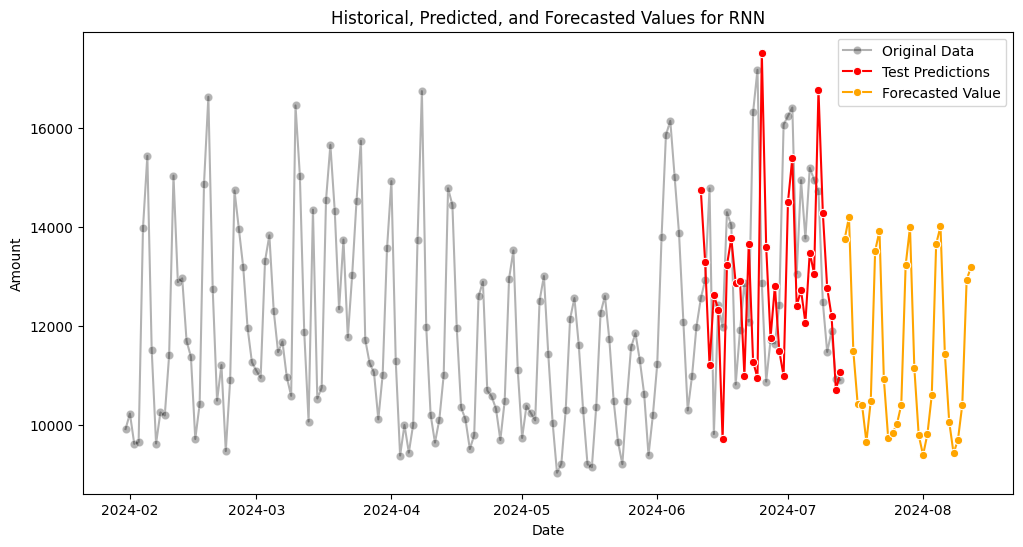

In [83]:
plt.figure(figsize=(12, 6))

# Original Data (black line with reduced visibility)
sns.lineplot(x=data.index[30:], y=data['amount'][30:], label='Original Data', color='black', marker='o', alpha=0.3)  # Adjust alpha

# Test Predictions (red line)
test_index = data.index[train_size + time_step + 1:]
sns.lineplot(x=test_index, y=y_pred_inverse.reshape(-1), label='Test Predictions', color='red', marker='o')

# Forecasted Values (orange line)
sns.lineplot(x=future_df.index, y=future_df["amount"].values, label='Forecasted Value', color='orange', marker='o')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Historical, Predicted, and Forecasted Values for RNN')
plt.legend()
plt.show()
